In [119]:
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
# from jupyterthemes import jtplot
# import requests
# from bs4 import BeautifulSoup
import git 

# jtplot.style()

If the cell above gives any errors for missing packages, simply:
`!pip install PACKAGE`,

where `PACKAGE` is the missing package, e.g. for git: it's 

`!pip install GitPython`

# Update data

In [120]:
git_dir = r'./COVID-19/'

g = git.cmd.Git(git_dir)
g.fetch()
g.pull()

'Already up-to-date.'

# Create the dataframe from the different files

In [121]:
ending = 'csv'
path_to_files = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'

all_paths = glob.glob(os.path.join(path_to_files, f'*.{ending}'))

In [122]:
all_paths

['./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv']

In [123]:
df_list = list()

for f in all_paths:
    foo = pd.read_csv(f)
    foo = pd.melt(foo, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name = ['Date'])
    foo['Date'] = pd.to_datetime(foo['Date'])
    foo.columns = foo.columns.str.replace('value', f.split("-")[-1].split(".")[0])
    foo['Province/State'].fillna(foo['Country/Region'], inplace = True)
    foo.set_index(['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'], inplace = True)
    df_list.append(foo)

In [124]:
df = pd.concat(df_list, axis = 1).reset_index()
df.shape

(23426, 8)

In [ ]:
# europe = dict()

# URL = "https://en.wikipedia.org/wiki/Member_state_of_the_European_Union"

# res = requests.get(URL).text
# soup = BeautifulSoup(res,'lxml')
# for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
#     data = items.find_all(['th','td'])
#     try:
#         country = data[0].a.text
#         europe[country] = 'EU'
#     except IndexError:
#         pass

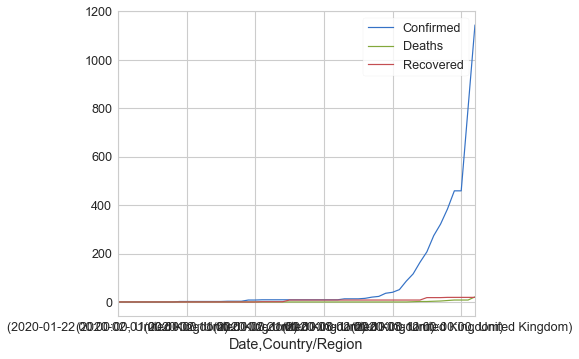

In [146]:
df[df['Country/Region'] == 'United Kingdom'].groupby(['Date', 'Country/Region']).sum()[['Confirmed', 'Deaths', 'Recovered']].plot()

In [35]:
# foo = pd.read_csv('countries.csv')
# foo = foo.copy()

In [36]:
# foo['Country_Name'] = foo['Country_Name'].apply(lambda x: x.split(',')[0])

In [87]:
# country_continent = dict(zip(foo.Country_Name, foo.Continent_Name))

In [111]:
country_continent = {'Afghanistan': 'Asia',
 'Albania': 'Europe',
 'Antarctica': 'Antarctica',
 'Algeria': 'Africa',
 'American Samoa': 'Oceania',
 'Andorra': 'Europe',
 'Angola': 'Africa',
 'Antigua and Barbuda': 'North America',
 'Azerbaijan': 'Asia',
 'Argentina': 'South America',
 'Australia': 'Oceania',
 'Austria': 'Europe',
 'Bahamas': 'North America',
 'Bahrain': 'Asia',
 'Bangladesh': 'Asia',
 'Armenia': 'Asia',
 'Barbados': 'North America',
 'Belgium': 'Europe',
 'Bermuda': 'North America',
 'Bhutan': 'Asia',
 'Bolivia': 'South America',
 'Bosnia and Herzegovina': 'Europe',
 'Botswana': 'Africa',
 'Bouvet Island (Bouvetoya)': 'Antarctica',
 'Brazil': 'South America',
 'Belize': 'North America',
 'British Indian Ocean Territory (Chagos Archipelago)': 'Asia',
 'Solomon Islands': 'Oceania',
 'British Virgin Islands': 'North America',
 'Brunei': 'Asia',
 'Bulgaria': 'Europe',
 'Myanmar': 'Asia',
 'Burundi': 'Africa',
 'Belarus': 'Europe',
 'Cambodia': 'Asia',
 'Cameroon': 'Africa',
 'Canada': 'North America',
 'Cape Verde': 'Africa',
 'Cayman Islands': 'North America',
 'Central African Republic': 'Africa',
 'Sri Lanka': 'Asia',
 'Chad': 'Africa',
 'Chile': 'South America',
 'China': 'Asia',
 'Taiwan*': 'Asia',
 'Christmas Island': 'Asia',
 'Cocos (Keeling) Islands': 'Asia',
 'Colombia': 'South America',
 'Comoros': 'Africa',
 'Mayotte': 'Africa',
 'Congo (Kinshasa)': 'Africa',
 'Cook Islands': 'Oceania',
 'Costa Rica': 'North America',
 'Croatia': 'Europe',
 'Cuba': 'North America',
 'Cyprus': 'Asia',
 'Czechia': 'Europe',
 'Benin': 'Africa',
 'Denmark': 'Europe',
 'Dominica': 'North America',
 'Dominican Republic': 'North America',
 'Ecuador': 'South America',
 'El Salvador': 'North America',
 'Equatorial Guinea': 'Africa',
 'Ethiopia': 'Africa',
 'Eritrea': 'Africa',
 'Estonia': 'Europe',
 'Faroe Islands': 'Europe',
 'Falkland Islands (Malvinas)': 'South America',
 'South Georgia and the South Sandwich Islands': 'Antarctica',
 'Fiji': 'Oceania',
 'Finland': 'Europe',
 'Ã…land Islands': 'Europe',
 'France': 'Europe',
 'French Guiana': 'South America',
 'French Polynesia': 'Oceania',
 'French Southern Territories': 'Antarctica',
 'Djibouti': 'Africa',
 'Gabon': 'Africa',
 'Georgia': 'Asia',
 'Gambia': 'Africa',
 'occupied Palestinian territory': 'Asia',
 'Germany': 'Europe',
 'Ghana': 'Africa',
 'Gibraltar': 'Europe',
 'Kiribati': 'Oceania',
 'Greece': 'Europe',
 'Greenland': 'North America',
 'Grenada': 'North America',
 'Guadeloupe': 'North America',
 'Guam': 'Oceania',
 'Guatemala': 'North America',
 'Guinea': 'Africa',
 'Guyana': 'South America',
 'Haiti': 'North America',
 'Heard Island and McDonald Islands': 'Antarctica',
 'Holy See (Vatican City State)': 'Europe',
 'Honduras': 'North America',
 'Hong Kong': 'Asia',
 'Hungary': 'Europe',
 'Iceland': 'Europe',
 'India': 'Asia',
 'Indonesia': 'Asia',
 'Iran': 'Asia',
 'Iraq': 'Asia',
 'Ireland': 'Europe',
 'Israel': 'Asia',
 'Italy': 'Europe',
 "Cote d'Ivoire": 'Africa',
 'Jamaica': 'North America',
 'Japan': 'Asia',
 'Kazakhstan': 'Asia',
 'Jordan': 'Asia',
 'Kenya': 'Africa',
 'Korea, South': 'Asia',
 'Kuwait': 'Asia',
 'Kyrgyz Republic': 'Asia',
 "Lao People's Democratic Republic": 'Asia',
 'Lebanon': 'Asia',
 'Lesotho': 'Africa',
 'Latvia': 'Europe',
 'Liberia': 'Africa',
 'Libyan Arab Jamahiriya': 'Africa',
 'Liechtenstein': 'Europe',
 'Lithuania': 'Europe',
 'Luxembourg': 'Europe',
 'Macao': 'Asia',
 'Madagascar': 'Africa',
 'Malawi': 'Africa',
 'Malaysia': 'Asia',
 'Maldives': 'Asia',
 'Mali': 'Africa',
 'Malta': 'Europe',
 'Martinique': 'North America',
 'Mauritania': 'Africa',
 'Mauritius': 'Africa',
 'Mexico': 'North America',
 'Monaco': 'Europe',
 'Mongolia': 'Asia',
 'Moldova': 'Europe',
 'Montenegro': 'Europe',
 'Montserrat': 'North America',
 'Morocco': 'Africa',
 'Mozambique': 'Africa',
 'Oman': 'Asia',
 'Namibia': 'Africa',
 'Nauru': 'Oceania',
 'Nepal': 'Asia',
 'Netherlands': 'Europe',
 'Netherlands Antilles': 'North America',
 'Curacao': 'North America',
 'Aruba': 'North America',
 'Sint Maarten (Netherlands)': 'North America',
 'Bonaire': 'North America',
 'New Caledonia': 'Oceania',
 'Vanuatu': 'Oceania',
 'New Zealand': 'Oceania',
 'Nicaragua': 'North America',
 'Niger': 'Africa',
 'Nigeria': 'Africa',
 'Niue': 'Oceania',
 'Norfolk Island': 'Oceania',
 'Norway': 'Europe',
 'Northern Mariana Islands': 'Oceania',
 'United States Minor Outlying Islands': 'North America',
 'Micronesia': 'Oceania',
 'Marshall Islands': 'Oceania',
 'Palau': 'Oceania',
 'Pakistan': 'Asia',
 'Panama': 'North America',
 'Papua New Guinea': 'Oceania',
 'Paraguay': 'South America',
 'Peru': 'South America',
 'Philippines': 'Asia',
 'Pitcairn Islands': 'Oceania',
 'Poland': 'Europe',
 'Portugal': 'Europe',
 'Guinea-Bissau': 'Africa',
 'Timor-Leste': 'Asia',
 'Puerto Rico': 'North America',
 'Qatar': 'Asia',
 'Reunion': 'Africa',
 'Romania': 'Europe',
 'Russia': 'Asia',
 'Rwanda': 'Africa',
 'Saint Barthelemy': 'North America',
 'Saint Helena': 'Africa',
 'Saint Kitts and Nevis': 'North America',
 'Anguilla': 'North America',
 'Saint Lucia': 'North America',
 'Saint Martin': 'North America',
 'Saint Pierre and Miquelon': 'North America',
 'Saint Vincent and the Grenadines': 'North America',
 'San Marino': 'Europe',
 'Sao Tome and Principe': 'Africa',
 'Saudi Arabia': 'Asia',
 'Senegal': 'Africa',
 'Serbia': 'Europe',
 'Seychelles': 'Africa',
 'Sierra Leone': 'Africa',
 'Singapore': 'Asia',
 'Slovakia': 'Europe',
 'Vietnam': 'Asia',
 'Slovenia': 'Europe',
 'Somalia': 'Africa',
 'South Africa': 'Africa',
 'Zimbabwe': 'Africa',
 'Spain': 'Europe',
 'South Sudan': 'Africa',
 'Western Sahara': 'Africa',
 'Sudan': 'Africa',
 'Suriname': 'South America',
 'Svalbard & Jan Mayen Islands': 'Europe',
 'Swaziland': 'Africa',
 'Sweden': 'Europe',
 'Switzerland': 'Europe',
 'Syrian Arab Republic': 'Asia',
 'Tajikistan': 'Asia',
 'Thailand': 'Asia',
 'Togo': 'Africa',
 'Tokelau': 'Oceania',
 'Tonga': 'Oceania',
 'Trinidad and Tobago': 'North America',
 'United Arab Emirates': 'Asia',
 'Tunisia': 'Africa',
 'Turkey': 'Asia',
 'Turkmenistan': 'Asia',
 'Turks and Caicos Islands': 'North America',
 'Tuvalu': 'Oceania',
 'Uganda': 'Africa',
 'Ukraine': 'Europe',
 'North Macedonia': 'Europe',
 'Egypt': 'Africa',
 'United Kingdom': 'Europe',
 'Guernsey': 'Europe',
 'Jersey': 'Europe',
 'Isle of Man': 'Europe',
 'Tanzania': 'Africa',
 'US': 'North America',
 'United States Virgin Islands': 'North America',
 'Burkina Faso': 'Africa',
 'Uruguay': 'South America',
 'Uzbekistan': 'Asia',
 'Venezuela': 'South America',
 'Wallis and Futuna': 'Oceania',
 'Samoa': 'Oceania',
 'Yemen': 'Asia',
 'Zambia': 'Africa',
 'Disputed Territory': 'Oceania',
 'Iraq-Saudi Arabia Neutral Zone': 'Asia',
 'United Nations Neutral Zone': 'Asia',
 'Spratly Islands': 'Asia',
 'Cruise Ship': 'Other',
 'Holy See': 'Holy See',
 'Eswatini':'Africa'}

In [115]:
# df['DeathRate'] = df['Deaths'] / df['Confirmed']
# df['RecoveredRate'] = df['Recovered'] / df['Confirmed']

In [128]:
df2 = df.copy()
df2['Date_1'] = df2['Date'] + pd.Timedelta(days = 1)
df2.rename(columns = {'Confirmed':'Confrimed_1',
                     'Deaths':'Deaths_1',
                     'Recovered':'Recovered_1',
                     'Date':'Date_Minus_1'}, inplace = True)


In [129]:
df2.head()

,Province/State,Country/Region,Date_Minus_1,Lat,Long,Confrimed_1,Deaths_1,Recovered_1,Date_1
0,"Adams, IN",US,2020-01-22,39.8522,-77.2865,0,0,0,2020-01-23
1,"Adams, IN",US,2020-01-23,39.8522,-77.2865,0,0,0,2020-01-24
2,"Adams, IN",US,2020-01-24,39.8522,-77.2865,0,0,0,2020-01-25
3,"Adams, IN",US,2020-01-25,39.8522,-77.2865,0,0,0,2020-01-26
4,"Adams, IN",US,2020-01-26,39.8522,-77.2865,0,0,0,2020-01-27


In [132]:
df3 = df.merge(df2[['Province/State',
                    'Country/Region',
                    'Confrimed_1',
                    'Deaths_1',
                    'Recovered_1',
                    'Date_1',
                    'Date_Minus_1']], how = 'left',
               left_on = ['Province/State', 'Country/Region', 'Date'],
               right_on=['Province/State', 'Country/Region', 'Date_1'])

In [134]:
df3['ConfirmedDaily'] = df3['Confirmed'] - df3['Confrimed_1']
df3['DeathsDaily'] = df3['Deaths'] - df3['Deaths_1']
df3['RecoveredDaily'] = df3['Recovered'] - df3['Recovered_1']

In [141]:
df3['ConfirmedDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Confirmed']
df3['DeathsDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Deaths']
df3['RecoveredDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Recovered']

del df3['Confrimed_1']
del df3['Deaths_1']
del df3['Recovered_1']
del df3['Date_1']
del df3['Date_Minus_1']

/Users/alexrpd/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [145]:
df3.DeathsDaily.sum(), df3.ConfirmedDaily.sum(), df3.RecoveredDaily.sum()

(5819.0, 156102.0, 72624.0)

In [147]:
df3['MonthYear'] = df3['Date'].dt.strftime('%b-%Y')


,Province/State,Country/Region,Date,Lat,Long,Confirmed,Deaths,Recovered,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear
0,"Adams, IN",US,2020-01-22,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020
1,"Adams, IN",US,2020-01-23,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020
2,"Adams, IN",US,2020-01-24,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020
3,"Adams, IN",US,2020-01-25,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020
4,"Adams, IN",US,2020-01-26,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020


In [150]:
df3['Continent'] = df3['Country/Region'].map(country_continent)

In [153]:
if len(df3[df3['Continent'].isna()]) == 0:
    print('All good')

All good


In [154]:
df3['DeathRate'] = df3['Deaths'] / df3['Confirmed']
df3['RecoveredRate'] = df3['Recovered'] / df3['Confirmed']

In [155]:
df3.head()

,Province/State,Country/Region,Date,Lat,Long,Confirmed,Deaths,Recovered,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear,Continent,DeathRate,RecoveredRate
0,"Adams, IN",US,2020-01-22,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
1,"Adams, IN",US,2020-01-23,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
2,"Adams, IN",US,2020-01-24,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
3,"Adams, IN",US,2020-01-25,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN
4,"Adams, IN",US,2020-01-26,39.8522,-77.2865,0,0,0,0.0,0.0,0.0,Jan-2020,North America,NaN,NaN


In [156]:
df3.to_csv('data_v0.4.csv')